In [1]:
!ls mycar/data

backup	  tub_3_22-10-25  tub_5_22-10-27  tub_7_22-11-01  zebra
data.zip  tub_4_22-10-25  tub_6_22-11-01  tub_8_22-11-03  zebra_dataset


In [2]:
import os
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

from sklearn.model_selection import train_test_split


print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.2.0


In [3]:
data_path = "./mycar/data"
data_path_zebra = os.path.join(data_path, "zebra")
data_path_without = os.path.join(data_path_zebra, "without")
data_path_with = os.path.join(data_path_zebra, "with")

In [ ]:
# Move images to directories that represent their classes
# NOTE: it is recommended to do this manually in CMD
directories_without = [
    "tub_3_22-10-25/images", "tub_5_22-10-27/images", "tub_7_22-11-01/images", 
    "tub_4_22-10-25/images", "tub_6_22-11-01/images", "tub_8_22-11-03/images", 
    "zebra_dataset/without_people"
]
directories_with = ["zebra_dataset/with_people"]

Path(data_path_without).mkdir(parents=True, exist_ok=True)
for directory in directories_without:
    directory_path = os.path.join(data_path, directory)
    for image_name in os.listdir(directory_path):
        shutil.move(os.path.join(directory_path, image_name), os.path.join(data_path_without, image_name))

Path(data_path_with).mkdir(parents=True, exist_ok=True)
for directory in directories_with:
    directory_path = os.path.join(data_path, directory)
    for image_name in os.listdir(directory_path):
        shutil.move(os.path.join(directory_path, image_name), os.path.join(data_path_with, image_name))

In [4]:
!ls ./mycar/data/zebra/without | wc -l
!ls ./mycar/data/zebra/with | wc -l

20612
2693


In [63]:
# Collected image paths and labels
images = []
labels = []

label_without = 0
label_with = 1

# Collect paths of images WITHOUT pedestrians
for image_name in os.listdir(data_path_without):
    images.append(os.path.join(data_path_without, image_name))
    labels.append(label_without)

# Collect paths of images WITH pedestrians
for image_name in os.listdir(data_path_with):
    images.append(os.path.join(data_path_with, image_name))
    labels.append(label_with)
        
images[:10]

['./mycar/data/zebra/without/4790_cam_image_array_.jpg',
 './mycar/data/zebra/without/2488_cam_image_array_.jpg',
 './mycar/data/zebra/without/14077_cam_image_array_.jpg',
 './mycar/data/zebra/without/7364_cam_image_array_.jpg',
 './mycar/data/zebra/without/317_cam_image_array_.jpg',
 './mycar/data/zebra/without/13208_cam_image_array_.jpg',
 './mycar/data/zebra/without/1844_cam_image_array_.jpg',
 './mycar/data/zebra/without/18852_cam_image_array_.jpg',
 './mycar/data/zebra/without/11363_cam_image_array_.jpg',
 './mycar/data/zebra/without/16630_cam_image_array_.jpg']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=2022)

In [65]:
mean = [0.4251, 0.4787, 0.4311]  # calculated in the separate notebook
std = [0.2203, 0.2276, 0.2366]  # calculated in the separate notebook


def apply_normalization(cv_image_rgb_uint8):
    image = np.float32(cv_image_rgb_uint8) / 255.0
    image -= mean
    image /= std
    return image


def reverse_normalization(cv_image_rgb_float32):
    image = cv_image_rgb_float32 * std
    image += mean
    image *= 255
    image = image.astype(np.uint8)
    return image

In [169]:
def transforms(cv_image_rgb):
    return apply_normalization(cv_image_rgb)

def load_image(image_path):
    image_bgr = cv2.imread(image_path.numpy().decode("utf-8"))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = transforms(image_rgb)
    return tf.convert_to_tensor(image_rgb)


def preprocess_labels(label):
    return tf.expand_dims(tf.cast(label, "float32"), axis=-1)


def configure_dataset(ds):
    # Keep the images in memory after they're loaded off disk during the first epoch
    ds = ds.cache()
    # Drop elements that cause errors
    ds = ds.apply(tf.data.experimental.ignore_errors())
    # Wrap the 'load_image' call inside 'tf.py_function' due to https://github.com/tensorflow/tensorflow/issues/30653
    ds = ds.map(lambda image_path, label: (tf.py_function(load_image, [image_path], tf.float32), tf.py_function(preprocess_labels, [label], np.float32)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Create batches
    ds = ds.batch(64)
    # prepare later elements while the current element is being processed
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = configure_dataset(ds_train)
ds_val = configure_dataset(ds_val)
ds_test = configure_dataset(ds_test)

2022-12-03 12:53:03.141394: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(64, 120, 160, 3)
(64, 1)


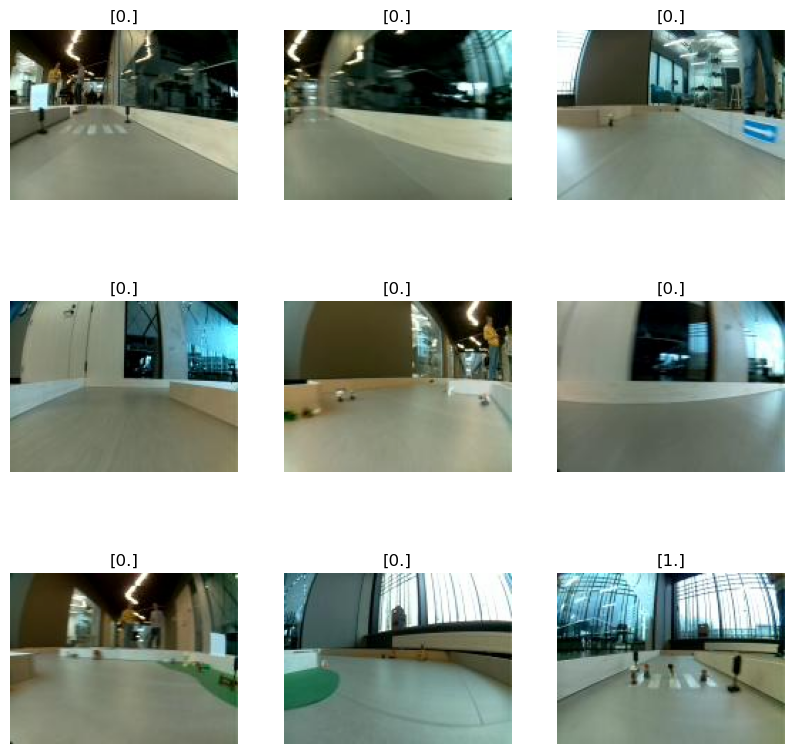

In [170]:
image_batch, label_batch = next(iter(ds_train))
print(image_batch.shape)
print(label_batch.shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(reverse_normalization(image_batch[-i].numpy()))
    plt.title(label_batch[-i].numpy())
    plt.axis("off")

In [171]:
# TODO Cropping
# TODO Augmentation
# TODO add dropout and batch norm
model = tf.keras.Sequential([
    #tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255),
    #tf.keras.layers.experimental.preprocessing.Normalization(axis=(0,1,2)), # mean - 0, std - 1 (https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization)
    tf.keras.layers.InputLayer(input_shape=(120, 160, 3)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
#model.build((64, 120, 160, 3))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 118, 158, 8)       224       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 59, 79, 8)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 57, 77, 16)        1168      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 28, 38, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 36, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 18, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 7488)            

In [172]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [173]:
image_batch, label_batch = next(iter(ds_train))
pred_batch = model.predict(a)
print(f"Image Batch Shape: {image_batch.shape}")
print(f"Label Batch Shape: {label_batch.shape}")
print(f"Predict Batch Shape: {pred_batch.shape}")
print(f"Image Batch DType: {image_batch.dtype}")
print(f"Label Batch DType: {label_batch.dtype}")
print(f"Predict Batch DType: {pred_batch.dtype}")
print(f"Image Batch Type: {type(image_batch)}")
print(f"Label Batch Type: {type(label_batch)}")
print(f"Predict Batch Type: {type(pred_batch)}")

Image Batch Shape: (64, 120, 160, 3)
Label Batch Shape: (64, 1)
Predict Batch Shape: (64, 1)
Image Batch DType: <dtype: 'float32'>
Label Batch DType: <dtype: 'float32'>
Predict Batch DType: float32
Image Batch Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Label Batch Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Predict Batch Type: <class 'numpy.ndarray'>


2022-12-03 12:53:10.208196: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [174]:
# TODO Add KFold validation to find better hyperparameters
history = model.fit(ds_train, epochs=10)

Epoch 1/10


ValueError: in user code:

    /gpfs/space/home/zaliznyi/miniconda3/envs/donkey/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /gpfs/space/home/zaliznyi/miniconda3/envs/donkey/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /gpfs/space/home/zaliznyi/miniconda3/envs/donkey/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /gpfs/space/home/zaliznyi/miniconda3/envs/donkey/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /gpfs/space/home/zaliznyi/miniconda3/envs/donkey/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /gpfs/space/home/zaliznyi/miniconda3/envs/donkey/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /gpfs/space/home/zaliznyi/miniconda3/envs/donkey/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:168 assert_input_compatibility
        layer_name + ' is incompatible with the layer: '

    ValueError: Input 0 of layer sequential_10 is incompatible with the layer: its rank is undefined, but the layer requires a defined rank.


In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_smaller.history['loss'])
plt.plot(history_smaller.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_smaller.history['accuracy'])
plt.plot(history_smaller.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [ ]:
# TODO add confusion matrix and choose a threshold using AUC
model.evaluate(X_test_norm, y_test, verbose=2)

In [ ]:
model.save(f"model")

In [ ]:
### Archived

In [ ]:
# def custom_mean_squared_error(y_true, y_pred):
#     print(y_true, y_pred)
#     return tf.math.reduce_mean(tf.square(y_true - y_pred))

In [ ]:
# # Rescaling and Normalization
# print(f"Before Normalization \nMin: {X_train.min()} \nMax: {X_train.max()} \nMean: {X_train.mean()} \nStd: {X_train.std()}")

# X_train_norm = X_train / 255.0
# X_test_norm = X_test / 255.0

# mu = X_train_norm.mean(axis=(0, 1, 2)) # finds mean of R, G and B separately
# std = X_train_norm.std(axis=(0, 1, 2)) # same for std

# X_train_norm = (X_train_norm - mu) / std
# X_test_norm = (X_test_norm - mu) / std

# print(f"After Normalization \nMin: {X_train_norm.min()} \nMax: {X_train_norm.max()} \nMean: {X_train_norm.mean()} \nStd: {X_train_norm.std()}")

In [ ]:
# # Read images into numpy arrays
# images_failed = []

# for image_path in data_without:
#     image_bgr = cv2.imread(image_path)
#     if image_bgr is None:
#         # print(f"Failed to read image {image_path}")
#         images_failed.append(image_path)
#         continue
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#     images.append(image_rgb)
#     labels.append(label_without)
    
# for image_path in data_with:
#     image_bgr = cv2.imread(image_path)
#     if image_bgr is None:
#         #print(f"Failed to read image {image_path}")
#         images_failed.append(image_path)
#         continue
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#     images.append(image_rgb)
#     labels.append(label_with)
    
# images = np.asarray(images)
# labels = np.asarray(labels)
    
# print(f"Failed to read {len(images_failed)} images")

In [ ]:
# # Collected image paths and labels
# images = []
# labels = []

# data_path = "./mycar/data"
# directories_without = [
#     "tub_3_22-10-25/images", "tub_5_22-10-27/images", "tub_7_22-11-01/images", 
#     "tub_4_22-10-25/images", "tub_6_22-11-01/images", "tub_8_22-11-03/images", 
#     "zebra_dataset/without_people"
# ]
# directories_with = ["zebra_dataset/with_people"]

# label_without = 0
# label_with = 1

# # Collect paths of images WITHOUT pedestrians
# for directory in directories_without:
#     directory_path = os.path.join(data_path, directory)
#     for image_name in os.listdir(directory_path):
#         images.append(os.path.join(directory_path, image_name))
#         labels.append(label_without)

# # Collect paths of images WITH pedestrians
# for directory in directories_with:
#     directory_path = os.path.join(data_path, directory)
#     for image_name in os.listdir(directory_path):
#         images.append(os.path.join(directory_path, image_name))
#         labels.append(label_with)
        
# images[:10]

In [ ]:
# seed = 111
# height, width = 120, 160
# batch_size = 32
# train_val_split = 0.2


# def tf_ds_train_val_test_split(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
#     assert (train_split + test_split + val_split) == 1
    
#     train_size = int(train_split * ds_size)
#     val_size = int(val_split * ds_size)
    
#     train_ds = ds.take(train_size)    
#     val_ds = ds.skip(train_size).take(val_size)
#     test_ds = ds.skip(train_size).skip(val_size)
    
#     return train_ds, val_ds, test_ds


# def files_count(directory_path):
#     count = 0
#     for _, _, files in os.walk(directory_path):
#         count += len(files)
#     return count


# ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_path_zebra,
#     validation_split=0.0,
#     subset="training",
#     image_size=(height, width),
#     batch_size=batch_size,
#     shuffle=True,
#     seed=seed,
# )
# ds_train, ds_val, ds_test = tf_ds_train_val_test_split(ds, files_count(data_path_zebra), train_split=0.7, val_split=0.2, test_split=0.1)

In [ ]:
# mean = 0

# count = 0
# for image_path in X_train:
#     image_bgr = cv2.imread(image_path)
#     if image_bgr is None:
#         #print(f"Failed to read image {image_path}")
#         #images_failed.append(image_path)
#         continue
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
#     image_rgb = image_rgb / 255.0
#     #mean += image_rgb.mean(axis=(0, 1, 2)) # finds mean of R, G and B separately
#     #std += image_rgb.std(axis=(0, 1, 2)) # same for std
#     print(image_rgb.shape)
#     print(image_rgb.mean(axis=(0, 1)))
#     print(image_rgb.std(axis=(0, 1, 2)))
#     break
    
#     count += 1
    
# mean /= count
# std /= count

# print(f"Mean: {mean}")
# print(f"Std: {std}")

In [ ]:
# a = 100
# b = 110
# example_images = X_train[a:b]
# example_labels = y_train[a:b]

# plt.figure(figsize=(10, 10))
# for i in range(9):
#     image = cv2.imread(example_images[-i])
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image)
#     plt.title(example_labels[-i])
#     plt.axis("off")